In [13]:
import pandas as pd
df = pd.read_excel("default of credit card clients.xls", skiprows=1)
print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month

In [14]:
df.rename(columns={"default payment next month": "target"}, inplace=True)
print("Target class distribution:\n", df['target'].value_counts(normalize=True))


Target class distribution:
 target
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [15]:
print("Missing values:\n", df.isnull().sum())


Missing values:
 ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
target       0
dtype: int64


In [16]:
df.drop(columns=['ID'], inplace=True)


In [17]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (24000, 23)
Test set size: (6000, 23)


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]


In [19]:
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("🏅 ROC AUC Score:", roc_auc_score(y_test, y_proba))


🔍 Accuracy: 0.819

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000

🏅 ROC AUC Score: 0.7778861909499183


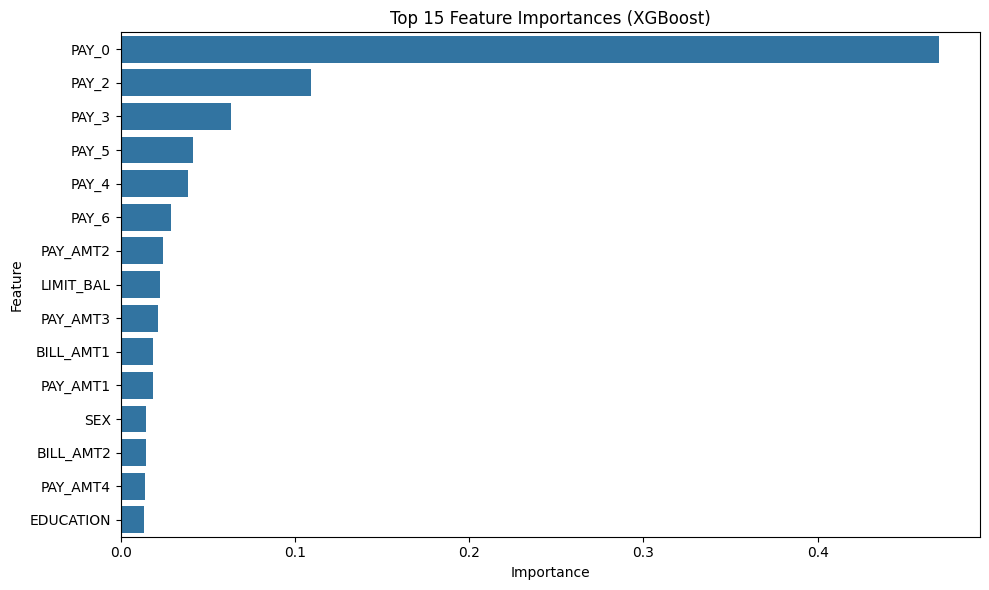

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
importances = xgb.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [21]:
import joblib
joblib.dump(xgb, 'xgboost_credit_model.pkl')



['xgboost_credit_model.pkl']

In [22]:
!pip install shap

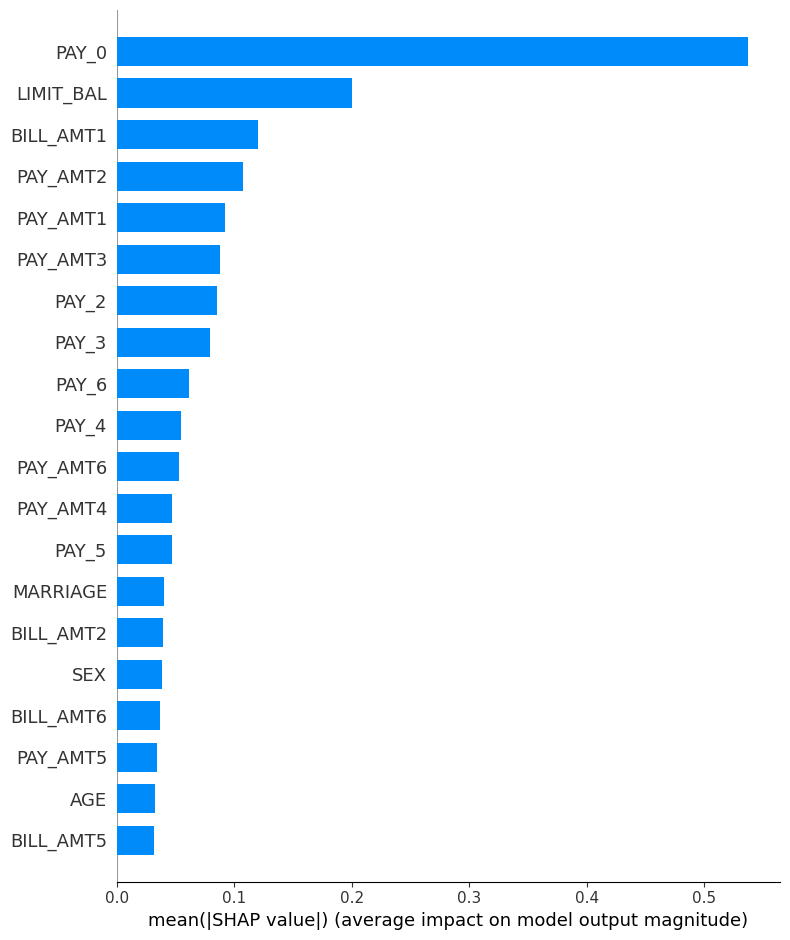

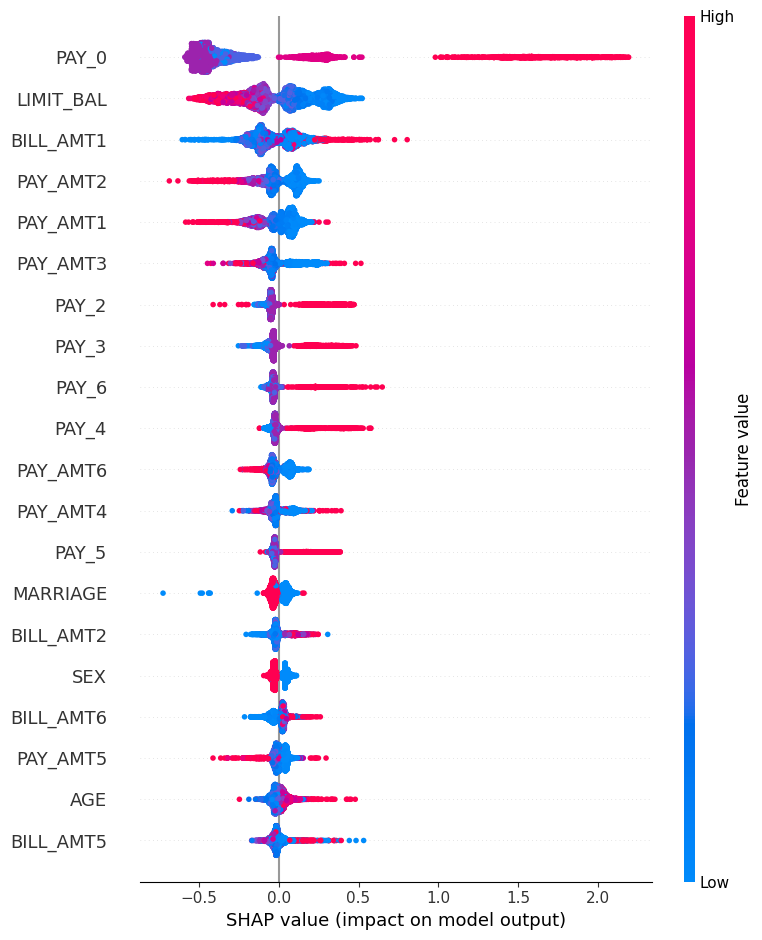

In [23]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_grid = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb_grid, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(" Best Parameters:", grid_search.best_params_)
print(" Best ROC AUC Score:", grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
 Best ROC AUC Score: 0.7821082959391811


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:, 1]


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def print_metrics(name, y_true, y_pred, y_proba):
    print(f"\n {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))
print_metrics("XGBoost", y_test, y_pred, y_proba)
print_metrics("Random Forest", y_test, rf_pred, rf_proba)
print_metrics("Logistic Regression", y_test, lr_pred, lr_proba)



 XGBoost
Accuracy: 0.819
F1 Score: 0.4697265625
ROC AUC: 0.7778861909499183

 Random Forest
Accuracy: 0.812
F1 Score: 0.4571703561116458
ROC AUC: 0.7505958244954782

 Logistic Regression
Accuracy: 0.8083333333333333
F1 Score: 0.36182019977802443
ROC AUC: 0.7089233456607739
